In [1]:
!pip install phik
!pip install -U scikit-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import uniform, loguniform

import matplotlib.pyplot as plt
import phik

HR analysts at the company "Work with Care" help businesses optimize personnel management: businesses provide data, and the analysts offer recommendations on how to avoid financial losses and employee turnover. In this, HR analysts benefit from machine learning, which allows them to respond to business questions more quickly and accurately.

The company has provided data on the characteristics of its employees, including their level of job satisfaction within the company. This information was obtained from feedback forms: employees fill out a survey, and the results calculate their satisfaction level, ranging from 0 to 1, where 0 means completely dissatisfied and 1 means fully satisfied.

Gathering data through such surveys is not easy: the company is large, and all employees must first be notified about the survey, and then it must be ensured that everyone completes it.

Tasks:

Build a model that can predict an employee’s level of satisfaction based on customer data.

Build a model that can predict, based on customer data, whether an employee will leave the company.

# Prediction of employee's satisfaction

## Read data

In [3]:
train_job_satisfaction_rate = pd.read_csv('https://code.s3.yandex.net/datasets/train_job_satisfaction_rate.csv', index_col='id')
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', index_col='id')
test_target_job_satisfaction_rate =pd.read_csv('https://code.s3.yandex.net/datasets/test_target_job_satisfaction_rate.csv',
                                               index_col='id')

## Preprocess data

### train_job_satisfaction_rate

In [4]:
train_job_satisfaction_rate.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [5]:
train_job_satisfaction_rate.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 155278 to 338347
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dept                   3994 non-null   object 
 1   level                  3996 non-null   object 
 2   workload               4000 non-null   object 
 3   employment_years       4000 non-null   int64  
 4   last_year_promo        4000 non-null   object 
 5   last_year_violations   4000 non-null   object 
 6   supervisor_evaluation  4000 non-null   int64  
 7   salary                 4000 non-null   int64  
 8   job_satisfaction_rate  4000 non-null   float64
dtypes: float64(1), int64(3), object(5)
memory usage: 312.5+ KB


In [6]:
train_job_satisfaction_rate[train_job_satisfaction_rate['dept'].isna()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
694746,NaN,junior,medium,5,no,no,4,21600,0.62
814624,NaN,junior,medium,3,no,no,4,24000,0.88
475114,NaN,junior,high,4,no,no,4,31200,0.63
497243,NaN,junior,medium,1,no,no,3,26400,0.28
168668,NaN,junior,low,3,no,no,4,18000,0.88
641150,NaN,junior,low,3,no,yes,4,12000,0.54


In [7]:
train_job_satisfaction_rate[train_job_satisfaction_rate['level'].isna()]

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
631073,sales,NaN,medium,1,no,no,4,27600,0.66
416327,sales,NaN,low,1,no,no,5,18000,0.73
135043,sales,NaN,medium,1,no,no,3,26400,0.30
998838,sales,NaN,medium,1,no,no,5,27600,0.71


In [8]:
train_job_satisfaction_rate.dept.value_counts()

sales         1512
technology     866
purchasing     610
marketing      550
hr             456
Name: dept, dtype: int64

In [9]:
train_job_satisfaction_rate.last_year_promo.value_counts()

no     3880
yes     120
Name: last_year_promo, dtype: int64

In [10]:
train_job_satisfaction_rate.last_year_violations.value_counts()

no     3441
yes     559
Name: last_year_violations, dtype: int64

For data preprocessing, we will create a simple pipeline that fills in all missing values in any column, complemented by OneHotEncoder and OrdinalEncoder for categorical variables. I decided to keep all categories (drop=None), as, from what I understand, dropping categories may create issues with training downstream models (models that are trained using the output of a model that used this data as input). We won't scale the values for now, as data analysis is yet to be done, and we don't want to train the scaler on outliers if any are present.

In [11]:
train_job_satisfaction_rate.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
155278,sales,junior,medium,2,no,no,1,24000,0.58
653870,hr,junior,high,2,no,no,5,38400,0.76
184592,sales,junior,low,1,no,no,2,12000,0.11
171431,technology,junior,low,4,no,no,2,18000,0.37
693419,hr,junior,medium,1,no,no,3,22800,0.20


In [12]:
categorical_features = ['dept', 'last_year_promo', 'last_year_violations']
ordinal_features = ['level', 'workload']

In [13]:
numerical_features = ['employment_years', 'salary', 'job_satisfaction_rate', 'supervisor_evaluation'] 

In [14]:
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

In [15]:
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [16]:
ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])

In [17]:
preprocessor = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features), 
    ('ord', ordinal_transformer, ordinal_features)
], remainder='passthrough')

In [18]:
train_job_satisfaction_rate_transformed = preprocessor.fit_transform(train_job_satisfaction_rate.replace({' ': np.nan}))

In [19]:
onehot_feature_names = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=categorical_features)

new_column_names = list(numerical_features) + list(onehot_feature_names) + list(ordinal_features)

In [20]:
train_job_satisfaction_rate_transformed = pd.DataFrame(train_job_satisfaction_rate_transformed, 
                                                       index=train_job_satisfaction_rate.index, columns = new_column_names)

In [21]:
train_job_satisfaction_rate_transformed.head()

,employment_years,salary,job_satisfaction_rate,supervisor_evaluation,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload
id,,,,,,,,,,,,
155278,2.0,24000.0,0.58,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
653870,2.0,38400.0,0.76,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184592,1.0,12000.0,0.11,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
171431,4.0,18000.0,0.37,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
693419,1.0,22800.0,0.20,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


### test_features + test_target_job_satisfation_rate

In [22]:
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


In [23]:
test_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


We will use pre-trained transformer to process the data: 

In [24]:
test_features['job_satisfaction_rate'] = test_target_job_satisfaction_rate['job_satisfaction_rate']

In [25]:
test_features_transformed = preprocessor.transform(test_features.replace({' ': np.nan}))

In [26]:
test_features_transformed = pd.DataFrame(test_features_transformed, index = test_features.index, columns = new_column_names)

In [27]:
test_features_transformed.head()

,employment_years,salary,job_satisfaction_rate,supervisor_evaluation,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload
id,,,,,,,,,,,,
485046,2.0,28800.0,0.79,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
686555,1.0,30000.0,0.72,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
467458,5.0,19200.0,0.64,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
418655,6.0,19200.0,0.60,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
789145,5.0,40800.0,0.75,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


## Exploratory data analysis

In [28]:
train_job_satisfaction_rate_transformed.describe()

,employment_years,salary,job_satisfaction_rate,supervisor_evaluation,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000
mean,3.718500,33926.700000,0.533995,3.476500,0.137500,0.15250,0.379500,0.21650,0.030000,0.139750,0.615000,1.333000
std,2.542513,14900.703838,0.225327,1.008812,0.344417,0.35955,0.485323,0.41191,0.170609,0.346771,0.644887,0.767632
min,1.000000,12000.000000,0.030000,1.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,22800.000000,0.360000,3.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000
50%,3.000000,30000.000000,0.560000,4.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.000000,1.000000,2.000000
75%,6.000000,43200.000000,0.710000,4.000000,0.000000,0.00000,1.000000,0.00000,0.000000,0.000000,1.000000,2.000000
max,10.000000,98400.000000,1.000000,5.000000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,2.000000,2.000000


In [29]:
test_features_transformed.describe()

,employment_years,salary,job_satisfaction_rate,supervisor_evaluation,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload
count,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.00000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,3.666500,34066.800000,0.54878,3.526500,0.139500,0.136500,0.38300,0.227500,0.031500,0.131000,0.598000,1.340500
std,2.537222,15398.436729,0.22011,0.996892,0.346554,0.343405,0.48624,0.419323,0.174708,0.337485,0.641562,0.766716
min,1.000000,12000.000000,0.03000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,22800.000000,0.38000,3.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,3.000000,30000.000000,0.58000,4.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000,2.000000
75%,6.000000,43200.000000,0.72000,4.000000,0.000000,0.000000,1.00000,0.000000,0.000000,0.000000,1.000000,2.000000
max,10.000000,96000.000000,1.00000,5.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,2.000000,2.000000


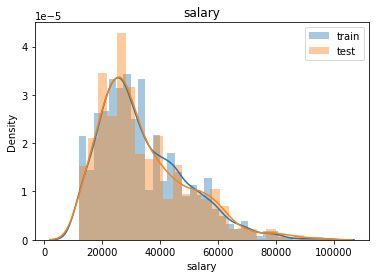

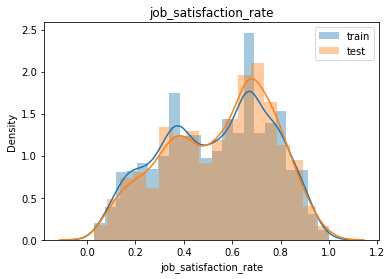

In [30]:
for i in ['salary', 'job_satisfaction_rate']:
    sns.distplot(train_job_satisfaction_rate_transformed[i], label='train')
    sns.distplot(test_features_transformed[i], label='test')
    plt.title(i)
    plt.legend()
    plt.show()

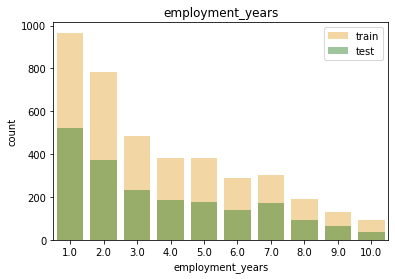

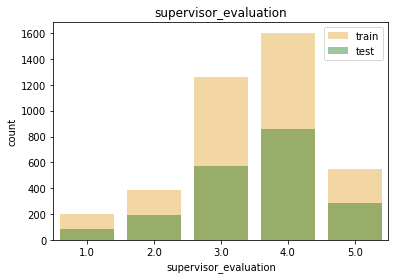

In [31]:
for i in ['employment_years', 'supervisor_evaluation']:
    sns.countplot(train_job_satisfaction_rate_transformed[i], label='train', color='orange', alpha=.4)
    sns.countplot(test_features_transformed[i], label='test', color='green', alpha=.4)
    plt.title(i)
    plt.legend()
    plt.show()    

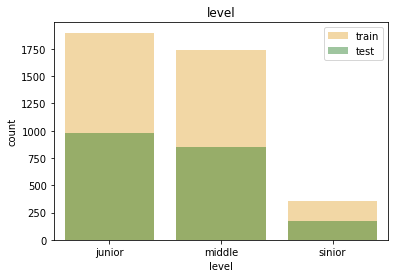

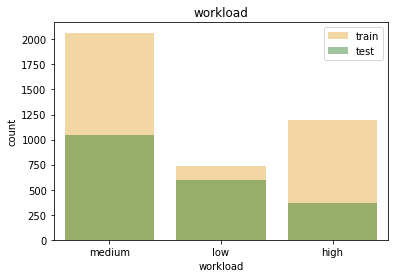

In [32]:
v1 = pd.DataFrame(preprocessor.named_transformers_['ord'].named_steps['ordinal'].inverse_transform(train_job_satisfaction_rate_transformed[ordinal_features]), 
                 columns = ordinal_features)
v2 = pd.DataFrame(preprocessor.named_transformers_['ord'].named_steps['ordinal'].inverse_transform(test_features_transformed[ordinal_features]), 
                 columns=ordinal_features)

for i in ordinal_features:
    sns.countplot(v1[i], label='train', color='orange', alpha=.4)
    sns.countplot(v2[i], label='test', color='green', alpha=.4)
    plt.title(i)
    plt.legend()
    plt.show()

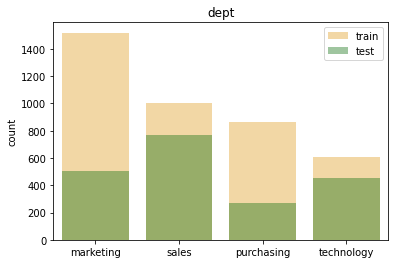

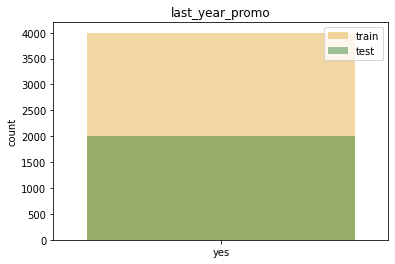

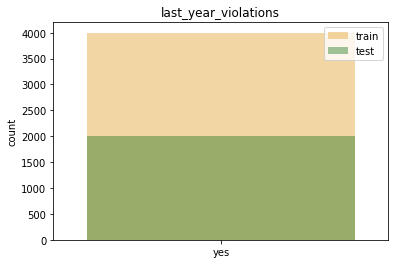

In [33]:
for i in categorical_features:
    columns_of_interest = [c for c in train_job_satisfaction_rate_transformed.columns if i in c]
    v1 = train_job_satisfaction_rate_transformed[columns_of_interest].idxmax(axis=1).str.replace(f'{i}_', '')
    v2 = test_features_transformed[columns_of_interest].idxmax(axis=1).str.replace(f'{i}_', '')
    sns.countplot(v1, label='train', color='orange', alpha=.4)
    sns.countplot(v2, label='test', color='green', alpha=.4)
    plt.title(i)
    plt.legend()
    plt.show()

In [34]:
test_features_transformed.phik_matrix(interval_cols = ['job_satisfaction_rate','salary'])

,employment_years,salary,job_satisfaction_rate,supervisor_evaluation,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload
employment_years,1.000000,0.494701,0.313525,0.000000,0.000000,0.000000,0.011051,0.000000,0.173637,0.066371,0.689747,0.202096
salary,0.494701,1.000000,0.171903,0.114588,0.042750,0.101887,0.229807,0.353831,0.193727,0.000000,0.749068,0.785872
job_satisfaction_rate,0.313525,0.171903,1.000000,0.769857,0.000000,0.086959,0.038203,0.043618,0.337002,0.554811,0.097007,0.052157
supervisor_evaluation,0.000000,0.114588,0.769857,1.000000,0.020516,0.015554,0.023991,0.012295,0.011704,0.189719,0.000000,0.035920
dept_marketing,0.000000,0.042750,0.000000,0.020516,1.000000,0.243256,0.474895,0.332343,0.000000,0.000000,0.013073,0.006518
dept_purchasing,0.000000,0.101887,0.086959,0.015554,0.243256,1.000000,0.469356,0.328237,0.000000,0.000000,0.000000,0.000000
dept_sales,0.011051,0.229807,0.038203,0.023991,0.474895,0.469356,1.000000,0.620148,0.000000,0.000000,0.000000,0.020950
dept_technology,0.000000,0.353831,0.043618,0.012295,0.332343,0.328237,0.620148,1.000000,0.000000,0.026236,0.021286,0.021914
last_year_promo_yes,0.173637,0.193727,0.337002,0.011704,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.118283,0.035565
last_year_violations_yes,0.066371,0.000000,0.554811,0.189719,0.000000,0.000000,0.000000,0.026236,0.000000,1.000000,0.017551,0.000000


In [35]:
train_job_satisfaction_rate_transformed.phik_matrix(interval_cols = ['job_satisfaction_rate','salary'])

,employment_years,salary,job_satisfaction_rate,supervisor_evaluation,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload
employment_years,1.000000,0.483419,0.325603,0.000000,0.026529,0.000000,0.000000,0.041082,0.183579,0.056808,0.682962,0.181941
salary,0.483419,1.000000,0.165830,0.000000,0.100427,0.065529,0.188538,0.285676,0.215025,0.010078,0.717761,0.788820
job_satisfaction_rate,0.325603,0.165830,1.000000,0.764364,0.057958,0.058312,0.020291,0.028991,0.190803,0.560348,0.080753,0.056128
supervisor_evaluation,0.000000,0.000000,0.764364,1.000000,0.009679,0.047272,0.029757,0.032968,0.013681,0.182042,0.000000,0.037023
dept_marketing,0.026529,0.100427,0.057958,0.009679,1.000000,0.260291,0.469516,0.321586,0.000000,0.013789,0.000000,0.000000
dept_purchasing,0.000000,0.065529,0.058312,0.047272,0.260291,1.000000,0.496399,0.341108,0.000000,0.000000,0.000000,0.012394
dept_sales,0.000000,0.188538,0.020291,0.029757,0.469516,0.496399,1.000000,0.600697,0.000000,0.000000,0.000000,0.000000
dept_technology,0.041082,0.285676,0.028991,0.032968,0.321586,0.341108,0.600697,1.000000,0.000000,0.000000,0.000000,0.000000
last_year_promo_yes,0.183579,0.215025,0.190803,0.013681,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.101668,0.058663
last_year_violations_yes,0.056808,0.010078,0.560348,0.182042,0.013789,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [36]:
x = train_job_satisfaction_rate_transformed.phik_matrix(interval_cols = ['job_satisfaction_rate','salary'])

In [37]:
x

,employment_years,salary,job_satisfaction_rate,supervisor_evaluation,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload
employment_years,1.000000,0.483419,0.325603,0.000000,0.026529,0.000000,0.000000,0.041082,0.183579,0.056808,0.682962,0.181941
salary,0.483419,1.000000,0.165830,0.000000,0.100427,0.065529,0.188538,0.285676,0.215025,0.010078,0.717761,0.788820
job_satisfaction_rate,0.325603,0.165830,1.000000,0.764364,0.057958,0.058312,0.020291,0.028991,0.190803,0.560348,0.080753,0.056128
supervisor_evaluation,0.000000,0.000000,0.764364,1.000000,0.009679,0.047272,0.029757,0.032968,0.013681,0.182042,0.000000,0.037023
dept_marketing,0.026529,0.100427,0.057958,0.009679,1.000000,0.260291,0.469516,0.321586,0.000000,0.013789,0.000000,0.000000
dept_purchasing,0.000000,0.065529,0.058312,0.047272,0.260291,1.000000,0.496399,0.341108,0.000000,0.000000,0.000000,0.012394
dept_sales,0.000000,0.188538,0.020291,0.029757,0.469516,0.496399,1.000000,0.600697,0.000000,0.000000,0.000000,0.000000
dept_technology,0.041082,0.285676,0.028991,0.032968,0.321586,0.341108,0.600697,1.000000,0.000000,0.000000,0.000000,0.000000
last_year_promo_yes,0.183579,0.215025,0.190803,0.013681,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.101668,0.058663
last_year_violations_yes,0.056808,0.010078,0.560348,0.182042,0.013789,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [38]:
for i in x.columns:
    print(x[i].sort_values())

supervisor_evaluation       0.000000
dept_purchasing             0.000000
dept_sales                  0.000000
dept_marketing              0.026529
dept_technology             0.041082
last_year_violations_yes    0.056808
workload                    0.181941
last_year_promo_yes         0.183579
job_satisfaction_rate       0.325603
salary                      0.483419
level                       0.682962
employment_years            1.000000
Name: employment_years, dtype: float64
supervisor_evaluation       0.000000
last_year_violations_yes    0.010078
dept_purchasing             0.065529
dept_marketing              0.100427
job_satisfaction_rate       0.165830
dept_sales                  0.188538
last_year_promo_yes         0.215025
dept_technology             0.285676
employment_years            0.483419
level                       0.717761
workload                    0.788820
salary                      1.000000
Name: salary, dtype: float64
dept_sales                  0.020291
dept_te

I would say that not all features in the training and test datasets have the same distribution: while salary and employment years are almost identical, dept and workload differ significantly. For example, in the test set, the percentage of workload=low is higher than in the training set. Also, the test set has more people from the sales department and fewer from the marketing department compared to the training set.

We won't address this for now — we assume that the training and test data were selected randomly (though it would be better to clarify this with the team responsible for data collection). Our goal is to test how the models we trained perform on real data, which we haven't artificially adjusted to fit any particular distributions.



## Data preparation

The only thing left to do for data preparation is to scale them.

In [39]:
scaler_preprocessor = ColumnTransformer(
    [
     ('num', StandardScaler(), numerical_features)
    ], 
    remainder='passthrough'
)

In [40]:
print(train_job_satisfaction_rate_transformed.shape)
train_job_satisfaction_rate_transformed = train_job_satisfaction_rate_transformed.drop_duplicates()
print(train_job_satisfaction_rate_transformed.shape)

(4000, 12)
(3752, 12)


In [41]:
X_train = pd.DataFrame(scaler_preprocessor.fit_transform(train_job_satisfaction_rate_transformed))
X_train.index = train_job_satisfaction_rate_transformed.index
X_train.columns = train_job_satisfaction_rate_transformed.columns

y_train = train_job_satisfaction_rate_transformed['job_satisfaction_rate']
X_train = X_train[[i for i in X_train.columns if i != 'job_satisfaction_rate']]

In [42]:
X_train.head()

,employment_years,salary,supervisor_evaluation,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload
id,,,,,,,,,,,
155278,-0.711613,-0.695081,-2.400409,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0
653870,-0.711613,0.261524,1.497593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184592,-1.102760,-1.492251,-1.425908,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
171431,0.070682,-1.093666,-1.425908,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
693419,-1.102760,-0.774798,-0.451408,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [43]:
X_test = pd.DataFrame(scaler_preprocessor.transform(test_features_transformed))
X_test.index = test_features_transformed.index
X_test.columns = test_features_transformed.columns

y_test = test_features_transformed['job_satisfaction_rate']
X_test = X_test[[i for i in X_test.columns if i != 'job_satisfaction_rate']]

In [44]:
X_test.head()

,employment_years,salary,supervisor_evaluation,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload
id,,,,,,,,,,,
485046,-0.711613,-0.376213,1.497593,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
686555,-1.102760,-0.296495,0.523093,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
467458,0.461829,-1.013949,0.523093,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
418655,0.852976,-1.013949,0.523093,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
789145,0.461829,0.420958,1.497593,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0


## Training

In [45]:
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    smape_score = np.mean(numerator / denominator) * 100
    return smape_score

### Model 1 (without hyperparameter selection)

In [46]:
lr = LinearRegression()

y_pred = cross_val_predict(lr, X_train, y_train, cv=5)

In [47]:
smape(y_train, y_pred)

26.79872482288113

### Model2 (with hyperparameter selection)

In [48]:
rf = RandomForestRegressor(random_state=42)

In [49]:
y_pred = cross_val_predict(rf, X_train, y_train, cv=5)

In [50]:
smape(y_train, y_pred)

13.831612730649143

In [51]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20], 
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2']
}

In [52]:
smape_score = make_scorer(smape, greater_is_better=False)

In [53]:
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=1, scoring=smape_score)

In [54]:
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best parameters:", best_params)
print("Best score:", -1*grid_search.best_score_)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
Best parameters: {'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best score: 13.85120836136323


The best model among all those tested is the random forest with default parameters.

In [55]:
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [56]:
smape(y_test.reindex(X_test.index), y_pred)

12.465971270322996

Intermediate conclusion: Data preparation and model training for predicting employee job satisfaction have been completed. The data arrived in excellent condition, requiring minimal preparation and processing. Two models were trained (linear regression and decision tree), and the decision tree successfully handled the task after hyperparameter tuning using grid search.

# Employee resign prediction

## Read data

In [57]:
train_quit = pd.read_csv('https://code.s3.yandex.net/datasets/train_quit.csv', index_col='id')
test_features = pd.read_csv('https://code.s3.yandex.net/datasets/test_features.csv', index_col='id')
test_target_quit = pd.read_csv('https://code.s3.yandex.net/datasets/test_target_quit.csv', index_col='id')

## Preprocess data

In [58]:
for df in [train_quit, test_features, test_target_quit]:
    display(df.head())

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary
id,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800
686555,hr,junior,medium,1,no,no,4,30000
467458,sales,middle,low,5,no,no,4,19200
418655,sales,middle,low,6,no,no,4,19200
789145,hr,middle,medium,5,no,no,5,40800


,quit
id,
999029,yes
372846,no
726767,no
490105,no
416898,yes


In [59]:
for df in [train_quit, test_features, test_target_quit]:
    display(df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 723290 to 853842
Data columns (total 9 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   4000 non-null   object
 1   level                  4000 non-null   object
 2   workload               4000 non-null   object
 3   employment_years       4000 non-null   int64 
 4   last_year_promo        4000 non-null   object
 5   last_year_violations   4000 non-null   object
 6   supervisor_evaluation  4000 non-null   int64 
 7   salary                 4000 non-null   int64 
 8   quit                   4000 non-null   object
dtypes: int64(3), object(6)
memory usage: 312.5+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 485046 to 771859
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   dept                   1998 non-null   object
 1   level                  1999 non-null   object
 2   workload               2000 non-null   object
 3   employment_years       2000 non-null   int64 
 4   last_year_promo        2000 non-null   object
 5   last_year_violations   2000 non-null   object
 6   supervisor_evaluation  2000 non-null   int64 
 7   salary                 2000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 140.6+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2000 entries, 999029 to 460332
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   quit    2000 non-null   object
dtypes: object(1)
memory usage: 31.2+ KB


None

In [60]:
for df in [train_quit, test_features, test_target_quit]:
    out = {}
    for c in ['dept', 'level', 'workload', 'last_year_promo',
       'last_year_violations', 'supervisor_evaluation', 'quit']:
        if c in df.columns:
            out[c] = df[c].unique()
    display((out))

{'dept': array(['sales', 'purchasing', 'marketing', 'technology', 'hr'],
       dtype=object),
 'level': array(['middle', 'junior', 'sinior'], dtype=object),
 'workload': array(['high', 'medium', 'low'], dtype=object),
 'last_year_promo': array(['no', 'yes'], dtype=object),
 'last_year_violations': array(['no', 'yes'], dtype=object),
 'supervisor_evaluation': array([4, 1, 3, 5, 2]),
 'quit': array(['no', 'yes'], dtype=object)}

{'dept': array(['marketing', 'hr', 'sales', 'purchasing', 'technology', nan, ' '],
       dtype=object),
 'level': array(['junior', 'middle', 'sinior', nan], dtype=object),
 'workload': array(['medium', 'low', 'high', ' '], dtype=object),
 'last_year_promo': array(['no', 'yes'], dtype=object),
 'last_year_violations': array(['no', 'yes'], dtype=object),
 'supervisor_evaluation': array([5, 4, 3, 1, 2])}

{'quit': array(['yes', 'no'], dtype=object)}

In [61]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit
id,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no
814010,sales,junior,medium,2,no,no,4,27600,no
155091,purchasing,middle,medium,5,no,no,1,37200,no
257132,sales,junior,medium,2,no,yes,3,24000,yes
910140,marketing,junior,medium,2,no,no,5,25200,no


### Adding new feature

Since we used the preprocessor from the previous task, including on the column train_job_satisfaction_rate, we will add a placeholder for it in the new data and later replace it with the prediction.

In [62]:
test_features['job_satisfaction_rate'] = 1

In [63]:
test_features

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,1
686555,hr,junior,medium,1,no,no,4,30000,1
467458,sales,middle,low,5,no,no,4,19200,1
418655,sales,middle,low,6,no,no,4,19200,1
789145,hr,middle,medium,5,no,no,5,40800,1
...,...,...,...,...,...,...,...,...,...
393147,marketing,junior,low,3,no,no,3,20400,1
109582,technology,middle,low,3,no,no,2,21600,1
305653,technology,junior,low,1,no,no,3,14400,1


In [64]:
tr = pd.DataFrame(preprocessor.transform(test_features[train_job_satisfaction_rate.columns].replace({' ': np.nan})), columns=new_column_names, 
                 index=test_features.index)

In [65]:
tr = pd.DataFrame(scaler_preprocessor.transform(tr), columns=tr.columns, 
                 index=test_features.index)

In [66]:
p = pd.Series(rf.predict(tr[[i for i in tr.columns if i != 'job_satisfaction_rate']]), 
             index = tr.index)

In [67]:
test_features['job_satisfaction_rate'] = p

In [68]:
test_features.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,job_satisfaction_rate
id,,,,,,,,,
485046,marketing,junior,medium,2,no,no,5,28800,0.864156
686555,hr,junior,medium,1,no,no,4,30000,0.681098
467458,sales,middle,low,5,no,no,4,19200,0.654457
418655,sales,middle,low,6,no,no,4,19200,0.657834
789145,hr,middle,medium,5,no,no,5,40800,0.782663


In [69]:
train_quit['job_satisfaction_rate'] = 1

In [70]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,1
814010,sales,junior,medium,2,no,no,4,27600,no,1
155091,purchasing,middle,medium,5,no,no,1,37200,no,1
257132,sales,junior,medium,2,no,yes,3,24000,yes,1
910140,marketing,junior,medium,2,no,no,5,25200,no,1


In [71]:
tr = pd.DataFrame(preprocessor.transform(train_quit[train_job_satisfaction_rate.columns]), columns=new_column_names, 
                 index=train_quit.index)

In [72]:
tr = pd.DataFrame(scaler_preprocessor.transform(tr), columns=tr.columns, 
                 index=train_quit.index)

In [73]:
p = pd.Series(rf.predict(tr[[i for i in tr.columns if i != 'job_satisfaction_rate']]), 
             index = tr.index)

In [74]:
train_quit['job_satisfaction_rate'] = p

In [75]:
train_quit.head()

,dept,level,workload,employment_years,last_year_promo,last_year_violations,supervisor_evaluation,salary,quit,job_satisfaction_rate
id,,,,,,,,,,
723290,sales,middle,high,2,no,no,4,54000,no,0.630050
814010,sales,junior,medium,2,no,no,4,27600,no,0.843293
155091,purchasing,middle,medium,5,no,no,1,37200,no,0.376717
257132,sales,junior,medium,2,no,yes,3,24000,yes,0.349165
910140,marketing,junior,medium,2,no,no,5,25200,no,0.756315


### Transformer

In [76]:
categorical_features = ['dept', 'last_year_promo', 'last_year_violations']
ordinal_features = ['level', 'workload', 'quit']
numerical_features = ['employment_years', 'salary','job_satisfaction_rate', 'supervisor_evaluation'] 

In [77]:
numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
])

In [78]:
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore'))
])

In [79]:
ordinal_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan))
])

In [80]:
preprocessor_for_classifier = ColumnTransformer([
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features), 
    ('ord', ordinal_transformer, ordinal_features)
], remainder='passthrough')

In [81]:
train_quit_transformed = preprocessor_for_classifier.fit_transform(train_quit)

In [82]:
onehot_feature_names = preprocessor_for_classifier.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=categorical_features)

new_column_names_pr2 = list(numerical_features) + list(onehot_feature_names) + list(ordinal_features)

In [83]:
train_quit_transformed = pd.DataFrame(train_quit_transformed, 
                                                       index=train_quit.index, columns = new_column_names_pr2)

In [84]:
train_quit_transformed.head()

,employment_years,salary,job_satisfaction_rate,supervisor_evaluation,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload,quit
id,,,,,,,,,,,,,
723290,2.0,54000.0,0.630050,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
814010,2.0,27600.0,0.843293,4.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0
155091,5.0,37200.0,0.376717,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0
257132,2.0,24000.0,0.349165,3.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,1.0
910140,2.0,25200.0,0.756315,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0


In [85]:
test_features['quit'] = test_target_quit['quit']

test_features_transformed = preprocessor_for_classifier.transform(test_features.replace({' ': np.nan}))
test_features_transformed = pd.DataFrame(test_features_transformed, 
                                                       index=test_features.index, columns = new_column_names_pr2)
test_features_transformed.head()

,employment_years,salary,job_satisfaction_rate,supervisor_evaluation,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload,quit
id,,,,,,,,,,,,,
485046,2.0,28800.0,0.864156,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
686555,1.0,30000.0,0.681098,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
467458,5.0,19200.0,0.654457,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
418655,6.0,19200.0,0.657834,4.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0
789145,5.0,40800.0,0.782663,5.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0


## Exploratory_data analysis

### Train vs test comparison

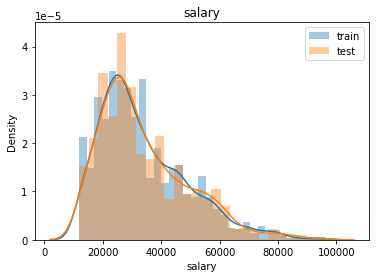

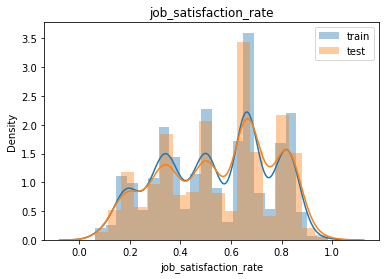

In [86]:
for i in ['salary','job_satisfaction_rate']:
    sns.distplot(train_quit_transformed[i], label='train')
    sns.distplot(test_features_transformed[i], label='test')
    plt.title(i)
    plt.legend()
    plt.show()

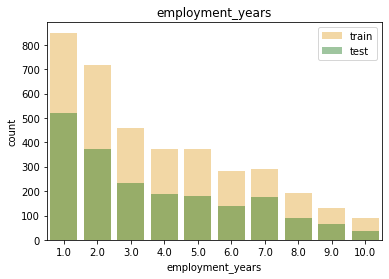

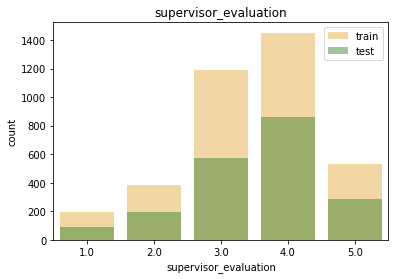

In [87]:
for i in ['employment_years', 'supervisor_evaluation']:
    sns.countplot(train_job_satisfaction_rate_transformed[i], label='train', color='orange', alpha=.4)
    sns.countplot(test_features_transformed[i], label='test', color='green', alpha=.4)
    plt.title(i)
    plt.legend()
    plt.show()   

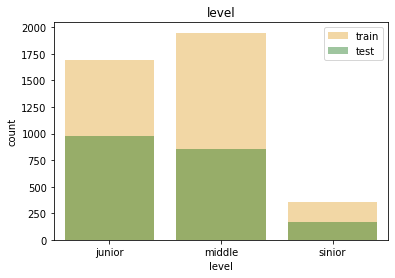

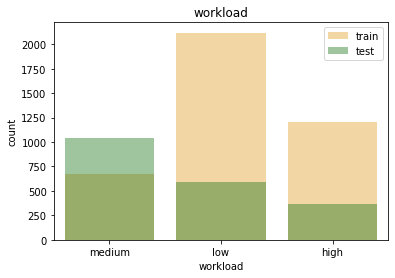

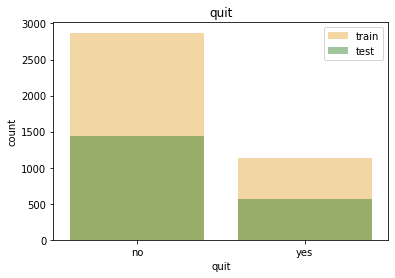

In [88]:
v1 = pd.DataFrame(preprocessor_for_classifier.named_transformers_['ord'].named_steps['ordinal'].inverse_transform(train_quit_transformed[ordinal_features]), 
                 columns = ordinal_features)
v2 = pd.DataFrame(preprocessor_for_classifier.named_transformers_['ord'].named_steps['ordinal'].inverse_transform(test_features_transformed[ordinal_features]), 
                 columns=ordinal_features)

for i in ordinal_features:
    sns.countplot(v1[i], label='train', color='orange', alpha=.4)
    sns.countplot(v2[i], label='test', color='green', alpha=.4)
    plt.title(i)
    plt.legend()
    plt.show()

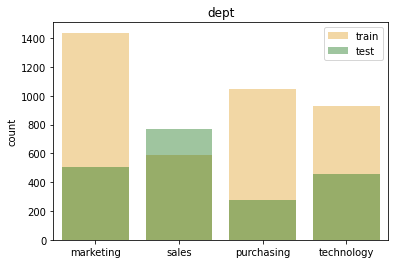

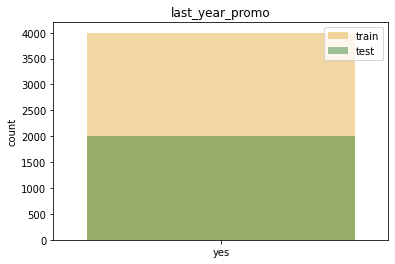

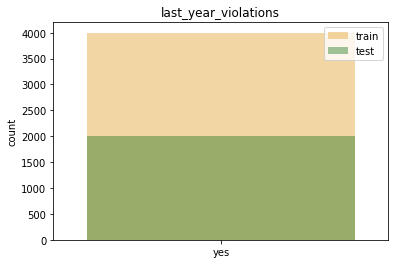

In [89]:
for i in categorical_features:
    columns_of_interest = [c for c in train_quit_transformed.columns if i in c]
    v1 = train_quit_transformed[columns_of_interest].idxmax(axis=1).str.replace(f'{i}_', '')
    v2 = test_features_transformed[columns_of_interest].idxmax(axis=1).str.replace(f'{i}_', '')
    sns.countplot(v1, label='train', color='orange', alpha=.4)
    sns.countplot(v2, label='test', color='green', alpha=.4)
    plt.title(i)
    plt.legend()
    plt.show()

In [90]:
test_features_transformed.phik_matrix(interval_cols = ['salary', 'job_satisfaction_rate'])

,employment_years,salary,job_satisfaction_rate,supervisor_evaluation,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload,quit
employment_years,1.000000,0.494701,0.438678,0.000000,0.000000,0.000000,0.011051,0.000000,0.173637,0.066371,0.689747,0.202096,0.605927
salary,0.494701,1.000000,0.288425,0.114588,0.042750,0.101887,0.229807,0.353831,0.193727,0.000000,0.749068,0.785872,0.508308
job_satisfaction_rate,0.438678,0.288425,1.000000,0.789693,0.051453,0.095374,0.077394,0.113314,0.444521,0.624296,0.216674,0.147077,0.572843
supervisor_evaluation,0.000000,0.114588,0.789693,1.000000,0.020516,0.015554,0.023991,0.012295,0.011704,0.189719,0.000000,0.035920,0.294738
dept_marketing,0.000000,0.042750,0.051453,0.020516,1.000000,0.243256,0.474895,0.332343,0.000000,0.000000,0.013073,0.006518,0.044013
dept_purchasing,0.000000,0.101887,0.095374,0.015554,0.243256,1.000000,0.469356,0.328237,0.000000,0.000000,0.000000,0.000000,0.000000
dept_sales,0.011051,0.229807,0.077394,0.023991,0.474895,0.469356,1.000000,0.620148,0.000000,0.000000,0.000000,0.020950,0.013582
dept_technology,0.000000,0.353831,0.113314,0.012295,0.332343,0.328237,0.620148,1.000000,0.000000,0.026236,0.021286,0.021914,0.000000
last_year_promo_yes,0.173637,0.193727,0.444521,0.011704,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.118283,0.035565,0.137762
last_year_violations_yes,0.066371,0.000000,0.624296,0.189719,0.000000,0.000000,0.000000,0.026236,0.000000,1.000000,0.017551,0.000000,0.174740


In [91]:
train_quit_transformed.phik_matrix(interval_cols = ['salary', 'job_satisfaction_rate'])

,employment_years,salary,job_satisfaction_rate,supervisor_evaluation,dept_marketing,dept_purchasing,dept_sales,dept_technology,last_year_promo_yes,last_year_violations_yes,level,workload,quit
employment_years,1.000000,0.491915,0.418025,0.000000,0.024791,0.000000,0.000000,0.000000,0.156494,0.000000,0.692676,0.213013,0.659093
salary,0.491915,1.000000,0.252089,0.055330,0.093166,0.068410,0.225068,0.264705,0.215043,0.086087,0.745104,0.793876,0.564154
job_satisfaction_rate,0.418025,0.252089,1.000000,0.782079,0.085571,0.000000,0.103630,0.086750,0.417208,0.608975,0.192479,0.160102,0.524015
supervisor_evaluation,0.000000,0.055330,0.782079,1.000000,0.016791,0.027559,0.000000,0.000000,0.032376,0.179228,0.007189,0.000000,0.245489
dept_marketing,0.024791,0.093166,0.085571,0.016791,1.000000,0.263245,0.465209,0.346753,0.000000,0.000000,0.000000,0.000000,0.000000
dept_purchasing,0.000000,0.068410,0.000000,0.027559,0.263245,1.000000,0.467805,0.348780,0.000000,0.071349,0.012676,0.000000,0.000000
dept_sales,0.000000,0.225068,0.103630,0.000000,0.465209,0.467805,1.000000,0.601551,0.000000,0.000000,0.000000,0.000000,0.000000
dept_technology,0.000000,0.264705,0.086750,0.000000,0.346753,0.348780,0.601551,1.000000,0.016232,0.065777,0.000000,0.000000,0.014061
last_year_promo_yes,0.156494,0.215043,0.417208,0.032376,0.000000,0.000000,0.000000,0.016232,1.000000,0.000000,0.110585,0.044388,0.157370
last_year_violations_yes,0.000000,0.086087,0.608975,0.179228,0.000000,0.071349,0.000000,0.065777,0.000000,1.000000,0.000000,0.014063,0.185071


In [92]:
train_quit_transformed = train_quit_transformed.drop_duplicates()

### Description of typical quit person

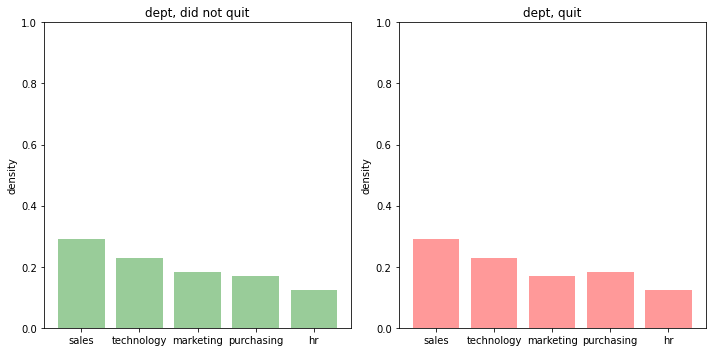

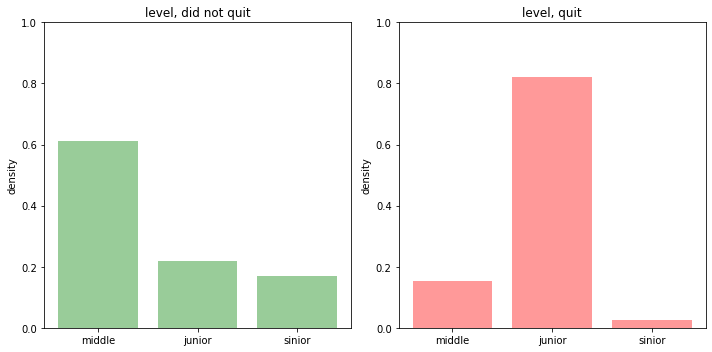

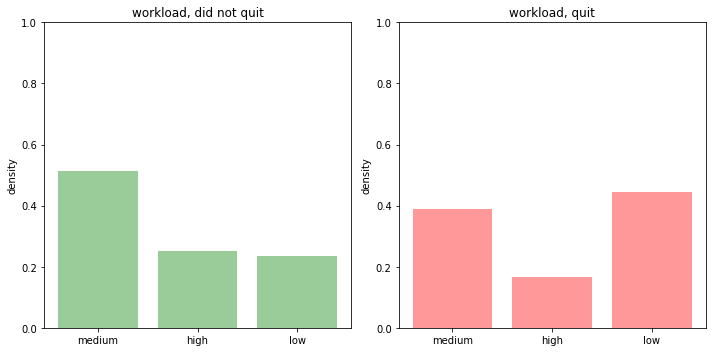

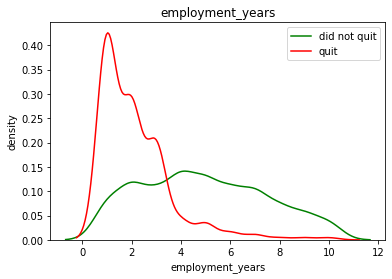

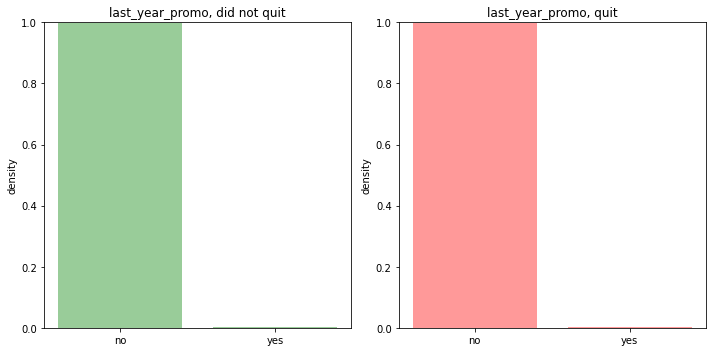

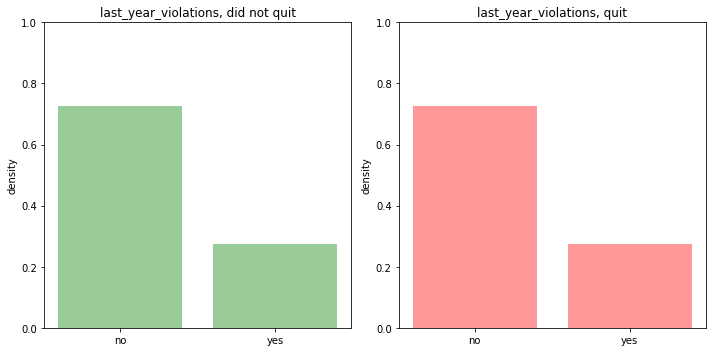

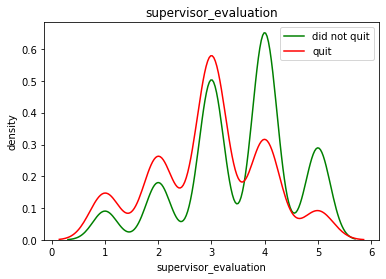

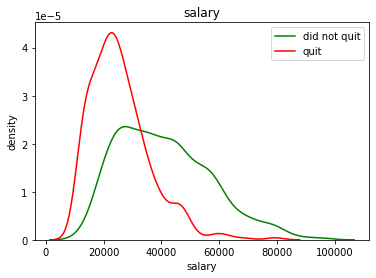

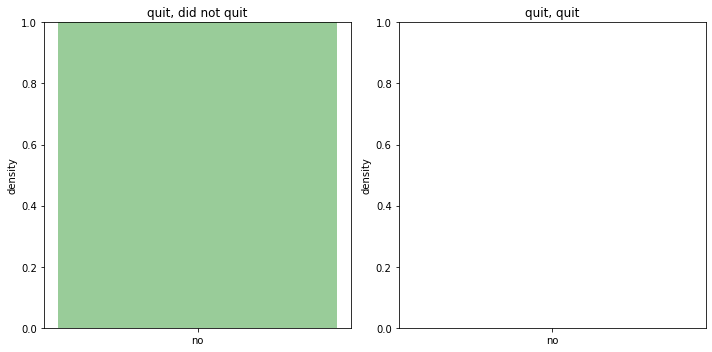

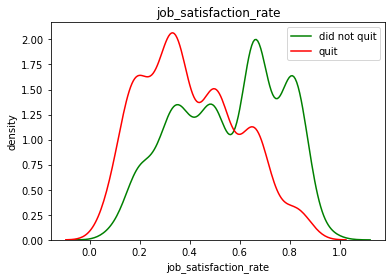

In [93]:
quit_no = train_quit_transformed.query('quit == 0')
quit_yes = train_quit_transformed.query('quit == 1')

for c in train_quit.columns:
    if c in categorical_features:
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        no = train_quit.reindex(quit_no.index)
        yes = train_quit.reindex(quit_yes.index)

        ax1.bar(range(len(yes[c].value_counts(normalize=True))), yes[c].value_counts(normalize=True), 
               color='green', alpha=.4, label='did not quit')
        ax1.set_title(f'{c}, did not quit')
        ax1.set_ylim(0, 1)
        ax1.set_xticks(range(len(no[c].value_counts(normalize=True))))
        order = no[c].value_counts(normalize=True).index
        ax1.set_xticklabels(order)
        ax1.set_ylabel('density')
        
        ax2.bar(range(len(yes[c].value_counts(normalize=True))), yes[c].value_counts(normalize=True).reindex(order), 
               color='red', alpha=.4, label='quit')
        ax2.set_title(f'{c}, quit')
        ax2.set_ylabel('density')
        ax2.set_ylim(0, 1)
        ax2.set_xticks(range(len(yes[c].value_counts(normalize=True))))
        ax2.set_xticklabels(order)

        plt.tight_layout()
        plt.show()
        
    elif c in numerical_features:
        fig, ax = plt.subplots()
        sns.kdeplot(quit_no[c], color='green', alpha=.4, label='did not quit')
        sns.kdeplot(quit_yes[c], color='red', alpha=.4, label='quit', ax=ax)

        plt.legend()
        plt.xlabel(c)
        plt.ylabel('density')
        plt.title(c)
        plt.show()
        
    elif c in ordinal_features and c in train_quit_transformed.columns:
        pr = preprocessor_for_classifier.named_transformers_['ord']['ordinal']
        no = pd.DataFrame(pr.inverse_transform(quit_no.T.reindex(ordinal_features).fillna(0).T), 
                          index=quit_no.index, columns = ordinal_features)
        yes = pd.DataFrame(pr.inverse_transform(quit_yes.T.reindex(ordinal_features).fillna(0).T), 
                          index=quit_yes.index, columns = ordinal_features)
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
        
        ax1.bar(range(len(no[c].value_counts(normalize=True))), no[c].value_counts(normalize=True), 
               color='green', alpha=.4, label='did not quit')
        ax1.set_title(f'{c}, did not quit')
        ax1.set_ylim(0, 1)
        ax1.set_xticks(range(len(no[c].value_counts(normalize=True))))
        order = no[c].value_counts(normalize=True).index
        ax1.set_xticklabels(order)
        ax1.set_ylabel('density')
        
        ax2.bar(range(len(yes[c].value_counts(normalize=True))), yes[c].value_counts(normalize=True).reindex(order), 
               color='red', alpha=.4, label='quit')
        ax2.set_title(f'{c}, quit')
        ax2.set_ylabel('density')
        ax2.set_ylim(0, 1)
        ax2.set_xticks(range(len(yes[c].value_counts(normalize=True))))
        ax2.set_xticklabels(order)

        plt.tight_layout()
        plt.show()

A typical profile of an employee who has left the company is the following: they work in the sales or technology departments at a junior level. They have a low workload, have been with the company for less than 4 years, have not received a promotion, but have received below-average performance reviews from their manager. Their salary ranges from 10,000 to 40,000 rubles.

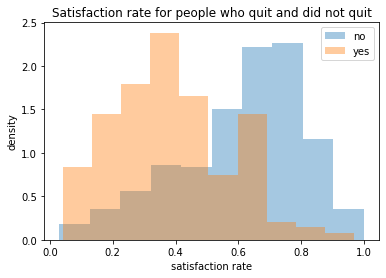

In [94]:
for _, d in test_target_job_satisfaction_rate.groupby(test_target_quit.quit):
    plt.hist(d['job_satisfaction_rate'], label = _, alpha=.4, density=True)
plt.xlabel('satisfaction rate')
plt.ylabel('density')
plt.title('Satisfaction rate for people who quit and did not quit')
plt.legend()
plt.show()

Indeed, job satisfaction level directly influences whether an employee will leave or not: employees who resigned had an average satisfaction level of around 0.4, while those who stayed have a satisfaction peak at approximately 0.7.

## Data preparation

In [95]:
numerical_features = ['employment_years', 'salary', 'job_satisfaction_rate']

In [96]:
scaler_preprocessor = ColumnTransformer(
    [
     ('num', StandardScaler(), numerical_features)
    ], 
    remainder='passthrough'
)

In [97]:
X_train = pd.DataFrame(scaler_preprocessor.fit_transform(train_quit_transformed))
X_train.index = train_quit_transformed.index
X_train.columns = train_quit_transformed.columns

y_train = train_quit_transformed['quit']
X_train = X_train[[i for i in X_train.columns if i != 'quit']]

In [98]:
X_test = pd.DataFrame(scaler_preprocessor.transform(test_features_transformed))
X_test.index = test_features_transformed.index
X_test.columns = test_features_transformed.columns

y_test = test_features_transformed['quit']
X_test = X_test[[i for i in X_test.columns if i != 'quit']]

## Training

### Model 1(without hyperparameter selection)

In [99]:
class proba_logreg(LogisticRegression):
    def predict(self, X):
        return LogisticRegression.predict_proba(self, X)

In [100]:
lr = LogisticRegression(random_state=42)
y_pred = cross_val_predict(proba_logreg(random_state=42), X_train, y_train, cv=5)

In [101]:
roc_auc_score(y_train, y_pred[:, 1])

0.9089710461018128

### Model 2(with hyperparameter selection)

In [102]:
param_dist = {
    'n_estimators': randint(50, 200),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'max_samples': uniform(0.1, 0.9),
    'ccp_alpha': uniform(0.0, 0.1)
}

random_search_rf = RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=5,
                                   random_state=42, 
                                  scoring='roc_auc')


random_search_rf.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   param_distributions={'bootstrap': [True, False],
                                        'ccp_alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f624e963c10>,
                                        'class_weight': [None, 'balanced',
                                                         'balanced_subsample'],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sq...
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7f624e9b1a60>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f624e963160>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f624e944cd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f624e963f70>},
                   random_state=42, scoring='roc_auc')

In [103]:
random_search_rf.best_score_

0.9145514328192459

### Model 3 (with hyperparameter selection)

In [104]:
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt'],
    'subsample': [0.8, 0.9, 1.0],
    'loss': ['deviance', 'exponential'],
    'max_leaf_nodes': [None, 10, 50, 100],
    'min_weight_fraction_leaf': [0.0, 0.1, 0.2],
    'warm_start': [True, False],
    'validation_fraction': [0.1, 0.2, 0.3],
    'n_iter_no_change': [5, 10, 20], 
    'tol': loguniform(1e-5, 1e-3),
    'ccp_alpha': uniform(0.0, 0.1) 
}


random_search_gb = RandomizedSearchCV(estimator=GradientBoostingClassifier(random_state=42),
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=5,
                                   random_state=42, 
                                  scoring='roc_auc')


random_search_gb.fit(X_train, y_train)
print(random_search_gb.best_score_)

0.9137875119282792


In [105]:
random_search_rf.best_estimator_

RandomForestClassifier(ccp_alpha=0.017336465350777208, criterion='entropy',
                       max_depth=10, max_samples=0.48264028704212025,
                       min_samples_leaf=6, min_samples_split=11,
                       n_estimators=53, random_state=42)

### Additional feature selection - attempt to improve the best model

Both classifiers, for which parameters were tuned, are handling the task well (ROC AUC > 0.91). Let's try to further improve the metric by selecting the most relevant features and retraining the best classifier.

In [106]:
selector = SelectFromModel(random_search_gb.best_estimator_)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)

In [107]:
X_train.iloc[:, selector.get_support()]

,employment_years,salary,job_satisfaction_rate,level
id,,,,
723290,-0.851101,1.038618,0.518599,1.0
814010,-0.851101,-0.584578,1.502319,0.0
155091,0.302478,0.005676,-0.650065,1.0
257132,-0.851101,-0.805922,-0.777164,0.0
910140,-0.851101,-0.732141,1.101077,0.0
...,...,...,...,...
778735,-0.851101,-0.879704,1.497518,0.0
106936,-1.235627,-1.174831,1.576224,0.0
775320,-1.235627,0.300802,0.286565,0.0


In [108]:
rf_classifier_stripped = RandomForestClassifier(random_state=42)
param_dist = {
    'n_estimators': randint(50, 200),
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 10),
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'max_samples': uniform(0.1, 0.9),
    'ccp_alpha': uniform(0.0, 0.1)
}

random_search_rf_stripped = RandomizedSearchCV(estimator=rf_classifier_stripped,
                                   param_distributions=param_dist,
                                   n_iter=10,
                                   cv=5,
                                   random_state=42, 
                                  scoring='roc_auc')

random_search_rf_stripped.fit(X_train.iloc[:, selector.get_support()], y_train)

print(random_search_rf_stripped.best_score_)

0.9142785170577078


Предскажем y_test, используя лучший классификатор:

In [109]:
y_pred = random_search_rf.best_estimator_.predict_proba(X_test)

In [110]:
roc_auc_score(y_test, y_pred[:, 1])

0.921661703115431

Feature selection has slightly worsened the classification. Therefore, the best model is recognized as the random forest with the following parameters:

ccp_alpha=0.017336465350777208
criterion='entropy'
max_depth=10
max_samples=0.48264028704212025
min_samples_leaf=6
min_samples_split=11
n_estimators=53
random_state=42
This model was trained using all available features.

## Conclusion

Two tasks were completed:

-Build a model that can predict employee job satisfaction based on client data;

-Build a model that can predict whether an employee will leave the company based on client data.

For the first task, the data was processed (missing values were removed, and data types were changed where necessary), analyzed, and two regressors were trained on this data: linear regression and random forest, with hyperparameter tuning. The random forest was recognized as the best model.

Additionally, data analysis revealed a significant pattern: employee satisfaction ratings are almost linearly dependent on the ratings given by their managers.

For the second task, the data was prepared similarly. The employee satisfaction level was additionally predicted using the model trained in the previous task.

For predicting employee turnover, three classifiers were trained: logistic regression, random forest, and gradient boosting (with hyperparameter tuning). The gradient boosting model was recognized as the best.

Data analysis also revealed a key finding: employee satisfaction ratings were significantly lower in the group of employees who left the company. Additionally, in this group, tenure and workload were lower compared to those who remained.

From this data analysis, several insights can be extracted for the business: in general, employees who leave are those who have started in new positions but do not feel that their knowledge and skills are valued. To enhance job satisfaction and reduce turnover, it may be beneficial to assign them higher workloads, even if their tenure is minimal—possibly by trusting them with simple projects. Evaluating their performance might also be approached more gently; it could be worthwhile to analyze how ratings are distributed among managers (some may evaluate performance much more strictly than others). It may be advisable to recommend that these stricter managers "soften" their evaluations for a trial period.